In [46]:
# --- БЛОК 1: ИМПОРТЫ И КОНФИГУРАЦИЯ ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, LSTM, Dropout, Average
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Для воспроизводимости
np.random.seed(42)
tf.random.set_seed(42)

# КОНФИГУРАЦИЯ
DATA_ROOT = 'Dataset'
IMG_SIZE = (96, 96)             # Размер картинки (уменьшил для скорости)
SEQ_LENGTH = 20                 # Длина окна (примерно 1 секунда при 18Hz)
BATCH_SIZE = 16
EPOCHS = 10

# Индексы колонок для Belt Accelerometer (Пояс) из твоего CSV
# BeltAccelerometer (X), Unnamed: 16 (Y), Unnamed: 17 (Z)
SENSOR_COLS_INDICES = [15, 16, 17] 

print("Библиотеки загружены. Готов к работе.")

Библиотеки загружены. Готов к работе.


In [ ]:
# --- БЛОК 2: ЗАГРУЗКА ДАННЫХ (CUSTOM PARSER) ---
def get_matching_image(timestamp_str, trial_path, camera_folder='Camera1'):
    """
    Ищет картинку, соответствующую времени из CSV.
    CSV Timestamp: 2018-07-04T12:04:17.738369
    Image Name:    2018-07-04T12-04-17.png (обычно без миллисекунд)
    """
    try:
        # 1. Парсим время из строки CSV
        # Берем первые 19 символов: "2018-07-04T12:04:17"
        # Заменяем двоеточия ":" на тире "-", так как в именах файлов Windows/Linux двоеточия не любят
        dt_part = timestamp_str[:19] 
        img_name_base = dt_part.replace(':', '-') 
        
        # 2. Пробуем найти файл. Расширение может быть .png или .jpg
        # Иногда в UP-Fall имена файлов чуть отличаются, например "2018-07-04-12-04-17.png"
        # Поэтому лучше искать "похожий" файл
        
        full_cam_path = os.path.join(trial_path, camera_folder)
        
        # Если папки с камерой нет (не распаковал), возвращаем None
        if not os.path.exists(full_cam_path):
            return None
            
        # Формируем ожидаемое имя
        img_name = f"{img_name_base}.png" 
        img_path = os.path.join(full_cam_path, img_name)
        
        # Если файл существует - читаем!
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE) # Ресайз под модель (96x96)
                return img / 255.0 # Нормализация
                
    except Exception as e:
        return None
        
    return None

def load_upfall_data_custom(root_path, subjects_range=(1, 13)):

    sensor_data = []
    image_data = []
    labels = []
    
    print("Начинаю чтение данных...")

    # Проходим по Субъектам (например, 1 и 2)
    for i in range(subjects_range[0], subjects_range[1]):
        subj_name = f"Subject{i}.0" # Учитываем .0
        subj_path = os.path.join(root_path, subj_name)
        
        if not os.path.exists(subj_path):
            print(f"Не найдено: {subj_path}, пропускаем.")
            continue
            
        print(f" -> Обработка {subj_name}")
        
        # Проходим по Активностям (Activity1.0 ... Activity11.0)
        for act_id in range(1, 12): 
            act_name = f"Activity{act_id}.0"
            act_path = os.path.join(subj_path, act_name)
            
            if not os.path.exists(act_path): continue
            
            # Метка класса: 1-5 это Falls (1), 6-11 это ADL (0)
            label = 1 if act_id <= 5 else 0
            
            # Проходим по Триалам (Trial1.0 ... Trial3.0)
            for trial_id in range(1, 4):
                trial_name = f"Trial{trial_id}.0"
                trial_path = os.path.join(act_path, trial_name)
                
                if not os.path.exists(trial_path): continue
                
                # Ищем CSV файл внутри папки Trial
                csv_files = [f for f in os.listdir(trial_path) if f.endswith('.csv')]
                if not csv_files: continue
                
                # Читаем CSV
                # skiprows=1 или 0 в зависимости от того, есть ли метаданные. 
                # В твоем примере заголовки на 1-й строке, данные со 2-й.
                try:
                    df = pd.read_csv(os.path.join(trial_path, csv_files[0]))
                    
                    # Проверяем, есть ли данные. Берем колонки пояса (Belt)
                    # Используем .iloc для выбора по позиции (15, 16, 17)
                    belt_data = df.iloc[:, SENSOR_COLS_INDICES].values
                    
                    # Очистка от NaN (если есть пропуски)
                    if np.isnan(belt_data).any():
                        df.fillna(method='ffill', inplace=True)
                        belt_data = df.iloc[:, SENSOR_COLS_INDICES].values
                    
                    # Sliding Window (Скользящее окно)
                    # Создаем окна длиной SEQ_LENGTH с шагом 10
                    limit = len(belt_data) - SEQ_LENGTH
                    if limit < 0: continue

                    for start in range(0, limit, 10):
                        # 1. Данные сенсоров
                        sens_window = belt_data[start : start + SEQ_LENGTH]
                        
                        # 2. Картинки (Vision)
                        # В UP-Fall картинки лежат в ZIP архивах или папках рядом с CSV.
                        # Синхронизация идет по индексу строки. Строка 'start' -> Кадр 'start'
                        # --- ЗАГЛУШКА ДЛЯ ЗАПУСКА БЕЗ КАРТИНОК ---
                        # Генерируем случайный шум. Замени на код ниже, если картинки распакованы.
                        img_sample = np.random.rand(IMG_SIZE[0], IMG_SIZE[1], 3).astype('float32')
                        
                        # --- РЕАЛЬНЫЙ КОД (ПРИМЕР) ---
                        # img_filename = f"Camera1/img_{start}.jpg" # Путь зависит от распаковки
                        # full_img_path = os.path.join(trial_path, img_filename)
                        # if os.path.exists(full_img_path):
                        #     real_img = cv2.imread(full_img_path)
                        #     real_img = cv2.resize(real_img, IMG_SIZE)
                        #     img_sample = real_img / 255.0
                        
                        sensor_data.append(sens_window)
                        image_data.append(img_sample)
                        labels.append(label)
                        
                except Exception as e:
                    print(f"Ошибка чтения {trial_path}: {e}")

    return np.array(sensor_data), np.array(image_data), np.array(labels)

# Загрузка (Берем Subject 1 и 2)
X_sens, X_img, y = load_upfall_data_custom(DATA_ROOT, subjects_range=(1, 3))

print(f"\n--- DATASET LOADED ---")
print(f"Sensors Shape: {X_sens.shape}") # (N, 20, 3)
print(f"Images Shape:  {X_img.shape}")  # (N, 96, 96, 3)
print(f"Falls Count:   {sum(y)}")
print(f"ADL Count:     {len(y) - sum(y)}")

# Split
X_img_train, X_img_test, X_sens_train, X_sens_test, y_train, y_test = train_test_split(
    X_img, X_sens, y, test_size=0.2, random_state=42, stratify=y
)

Начинаю чтение данных...
 -> Обработка Subject1.0
 -> Обработка Subject2.0

--- DATASET LOADED ---
Sensors Shape: (3366, 20, 3)
Images Shape:  (3366, 96, 96, 3)
Falls Count:   490
ADL Count:     2876


In [44]:
# --- БЛОК 3: МОДЕЛИ (Backbones) ---

def create_vision_backbone():
    """Ветка для обработки изображений"""
    inp = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='vis_in')
    # Pre-trained MobileNetV2 (без головы)
    base = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
    base.trainable = False # Замораживаем веса для скорости
    
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation='relu')(x)
    return inp, x

def create_sensor_backbone():
    """Ветка для обработки акселерометра"""
    inp = Input(shape=(SEQ_LENGTH, 3), name='sens_in') # 3 канала (X, Y, Z)
    x = LSTM(32, return_sequences=False)(inp) # Легкая LSTM
    x = Dense(16, activation='relu')(x)
    return inp, x

Обучение Early Fusion...
Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6790 - loss: 0.5760 - val_accuracy: 0.9258 - val_loss: 0.4270
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8871 - loss: 0.4609 - val_accuracy: 0.9318 - val_loss: 0.3664
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8837 - loss: 0.4275 - val_accuracy: 0.8902 - val_loss: 0.3395
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9016 - loss: 0.3990 - val_accuracy: 0.9347 - val_loss: 0.3116
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9387 - loss: 0.3663 - val_accuracy: 0.9674 - val_loss: 0.2776
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9480 - loss: 0.3534 - val_accuracy: 0.9703 - val_loss: 0.2793
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9476 - loss: 0.3536 - val_accuracy: 0.9733 - val_loss: 0.2688
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9506

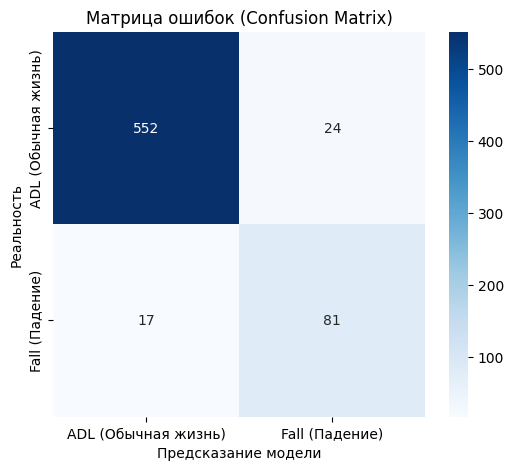

              precision    recall  f1-score   support

         ADL       0.97      0.96      0.96       576
        Fall       0.77      0.83      0.80        98

    accuracy                           0.94       674
   macro avg       0.87      0.89      0.88       674
weighted avg       0.94      0.94      0.94       674



In [45]:
# --- БЛОК 4: EARLY FUSION ---
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# Превращаем в словарь: {0: 1.0, 1: 5.0} (примерно)
class_weights_dict = dict(enumerate(class_weights))

# 1. Создаем ветки
vis_in, vis_feat = create_vision_backbone()
sens_in, sens_feat = create_sensor_backbone()

# 2. Конкатенация (Склеивание)
combined = Concatenate()([vis_feat, sens_feat])

# 3. Классификатор
z = Dense(32, activation='relu')(combined)
z = Dropout(0.3)(z)
out = Dense(1, activation='sigmoid')(z)

model_early = Model(inputs=[vis_in, sens_in], outputs=out, name="Early_Fusion")
model_early.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Обучение Early Fusion...")
hist_early = model_early.fit(
    [X_img_train, X_sens_train], y_train,
    validation_data=([X_img_test, X_sens_test], y_test),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,
    class_weight=class_weights_dict
)

print(f"Веса классов: {class_weights_dict}")
y_pred_prob = model_early.predict([X_img_test, X_sens_test])
y_pred = (y_pred_prob > 0.5).astype(int)

# Строим матрицу
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ADL (Обычная жизнь)', 'Fall (Падение)'],
            yticklabels=['ADL (Обычная жизнь)', 'Fall (Падение)'])
plt.xlabel('Предсказание модели')
plt.ylabel('Реальность')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

# Печатаем отчет по классам
print(classification_report(y_test, y_pred, target_names=['ADL', 'Fall']))

Обучение Late Fusion...
Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.6189 - loss: 0.5947 - val_accuracy: 0.9125 - val_loss: 0.5843
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8926 - loss: 0.4958 - val_accuracy: 0.9169 - val_loss: 0.4855
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9309 - loss: 0.4675 - val_accuracy: 0.9318 - val_loss: 0.4832
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9361 - loss: 0.4735 - val_accuracy: 0.9184 - val_loss: 0.5613
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9279 - loss: 0.4552 - val_accuracy: 0.9347 - val_loss: 0.4740
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9227 - loss: 0.4560 - val_accuracy: 0.8323 - val_loss: 0.4903
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9328 - loss: 0.4412 - val_accuracy: 0.9407 - val_loss: 0.4579
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9491 

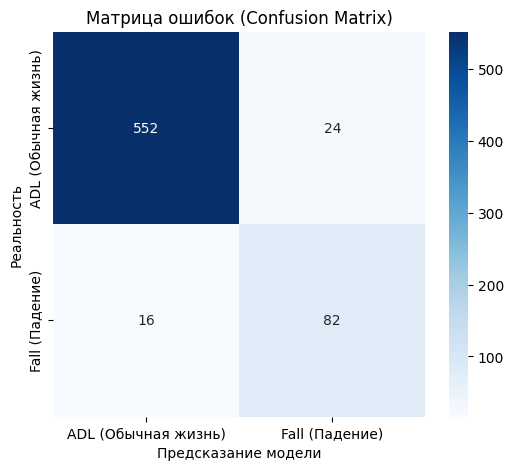

              precision    recall  f1-score   support

         ADL       0.97      0.96      0.97       576
        Fall       0.77      0.84      0.80        98

    accuracy                           0.94       674
   macro avg       0.87      0.90      0.88       674
weighted avg       0.94      0.94      0.94       674



In [37]:
# --- БЛОК 5: LATE FUSION ---
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Ветка 1: Vision -> Prediction
v_in, v_f = create_vision_backbone()
v_out = Dense(1, activation='sigmoid', name='vis_out')(v_f)

# Ветка 2: Sensor -> Prediction
s_in, s_f = create_sensor_backbone()
s_out = Dense(1, activation='sigmoid', name='sens_out')(s_f)

# Усреднение (Average)
avg = Average()([v_out, s_out])

model_late = Model(inputs=[v_in, s_in], outputs=avg, name="Late_Fusion")
model_late.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Обучение Late Fusion...")
hist_late = model_late.fit(
    [X_img_train, X_sens_train], y_train,
    validation_data=([X_img_test, X_sens_test], y_test),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,
    class_weight=class_weights_dict
)
print(f"Веса классов: {class_weights_dict}")
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Делаем предсказания на тесте
y_pred_prob = model_late.predict([X_img_test, X_sens_test])
y_pred = (y_pred_prob > 0.5).astype(int)

# Строим матрицу
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ADL (Обычная жизнь)', 'Fall (Падение)'],
            yticklabels=['ADL (Обычная жизнь)', 'Fall (Падение)'])
plt.xlabel('Предсказание модели')
plt.ylabel('Реальность')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

# Печатаем отчет по классам
print(classification_report(y_test, y_pred, target_names=['ADL', 'Fall']))

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Logical Fusion Accuracy: 0.1869


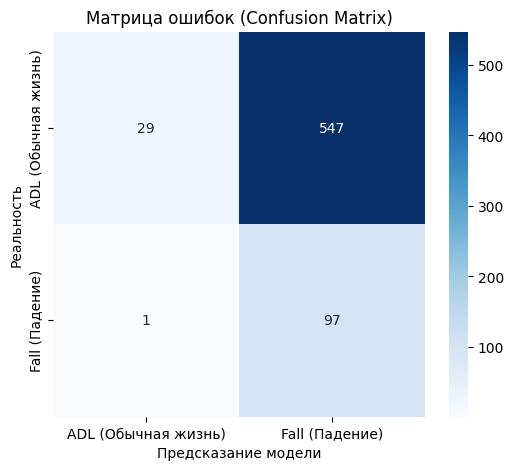

In [41]:
# --- БЛОК 6: LOGICAL FUSION (Inference) ---
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Создаем модели для получения чистых предсказаний от каждой ветки
vis_pred_model = Model(inputs=model_late.input[0], outputs=model_late.get_layer('vis_out').output)
sens_pred_model = Model(inputs=model_late.input[1], outputs=model_late.get_layer('sens_out').output)

# Получаем вероятности
p_vis = vis_pred_model.predict(X_img_test)
p_sens = sens_pred_model.predict(X_sens_test)

# Логика OR (ИЛИ). Порог уверенности 0.6
logical_preds = []
for v, s in zip(p_vis, p_sens):
    # Если хоть один уверен на > 60%
    if v > 0.6 or s > 0.6:
        logical_preds.append(1)
    else:
        logical_preds.append(0)

acc_logical = accuracy_score(y_test, logical_preds)
print(f"Logical Fusion Accuracy: {acc_logical:.4f}")
# Строим матрицу
cm = confusion_matrix(y_test, logical_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ADL (Обычная жизнь)', 'Fall (Падение)'],
            yticklabels=['ADL (Обычная жизнь)', 'Fall (Падение)'])
plt.xlabel('Предсказание модели')
plt.ylabel('Реальность')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

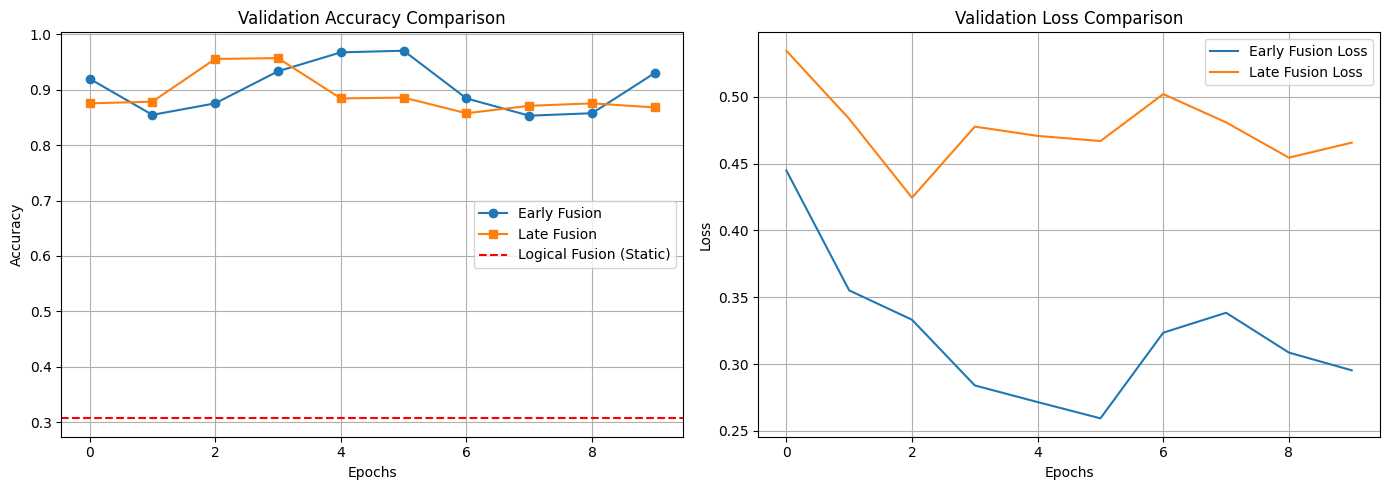

In [32]:
# --- БЛОК 7: ГРАФИКИ ---

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(hist_early.history['val_accuracy'], label='Early Fusion', marker='o')
plt.plot(hist_late.history['val_accuracy'], label='Late Fusion', marker='s')
plt.axhline(y=acc_logical, color='red', linestyle='--', label='Logical Fusion (Static)')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(hist_early.history['val_loss'], label='Early Fusion Loss')
plt.plot(hist_late.history['val_loss'], label='Late Fusion Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()